# Implement Algorithms
## CS5304 Data Science in the Wild

In [1]:
import pandas
import sklearn
from sklearn.model_selection import train_test_split

## Continued Feature Generation / Data Cleaning

In [ ]:
forAlgos_df = pandas.read_csv('./forAlgos.csv')
forAlgos_LetterGrade_df = forAlgos_df['GRADE']
one_hot = pandas.get_dummies(forAlgos_df.CUISINE_DESCRIPTION, prefix='CUISINE')
forAlgos_df = forAlgos_df.drop('CUISINE_DESCRIPTION', axis=1)
forAlgos_df = forAlgos_df.join(one_hot)
one_hot = pandas.get_dummies(forAlgos_df.BORO, prefix='BORO')
forAlgos_df = forAlgos_df.drop('BORO', axis=1)
forAlgos_df = forAlgos_df.join(one_hot)
def filterGrade(g):
    return g == 'A' | g == 'B' | g == 'C'
forAlgos_df = forAlgos_df[forAlgos_df['GRADE'].isin(['A', 'B', 'C'])]

In [ ]:
# forAlgos_df['GRADE'].replace({"A": 90, "B": 80, "C": 70}, inplace=True)

In [ ]:
forAlgos_df['GRADENUMERICAL'] = forAlgos_df['GRADE'].map({"A": 90, "B": 80, "C": 70})

In [ ]:
# drop the 'Unnamed: 0' column
forAlgos_df = forAlgos_df[forAlgos_df.columns[~forAlgos_df.columns.isin(['Unnamed: 0'])]]

In [ ]:
# split data into train and holdout sets
X = forAlgos_df[forAlgos_df.columns[~forAlgos_df.columns.isin(['GRADE','GRADENUMERICAL'])]]
# Y: Letter Grade (for logistic regression); Y_gradeNumerical: Numerical Grade (for linear regression)
Y = forAlgos_df[['GRADE']]
Y_gradeNumerical = forAlgos_df[['GRADENUMERICAL']]

x_train, x_holdout, y_train, y_holdout = train_test_split(X,Y_gradeNumerical, test_size=0.2)
x_train_classify, x_holdout_classify, y_train_classify, y_holdout_classify = train_test_split(X,Y, test_size=0.2)

## Linear Regression - Cross Validation

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

In [ ]:
def linearRegressionCrossValidation(X, y):
    lm = LinearRegression()
    scores = cross_val_score(lm, X, y, cv=10, scoring = 'neg_mean_squared_error')
    mse_scores = -scores
    rmse_scores = np.sqrt(mse_scores)
    averageRMSE = rmse_scores.mean()
    return averageRMSE

In [ ]:
# Cross Validation RMSE score using ALL FEATURES
linearRegressionCrossValidation(x_train, y_train)

3.80170132688362

## Linear Regression - Finding Feature Importance

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn import metrics

In [ ]:
# loop through all the features to see the change in RMSE
featureCount = X.shape[1]
rmseArray = []
for i in range(featureCount):
    X_new = SelectKBest(f_regression, k=i).fit_transform(x_train,y_train)
    rmseArray.append(linearRegressionCrossValidation(X_new, y_train))

In [ ]:
x_coords = []
y_coords = []
for i, v in enumerate(rmseArray):
    x_coords.append(i)
    y_coords.append(v)
x_coords = x_coords[1:]
y_coords = y_coords[1:]

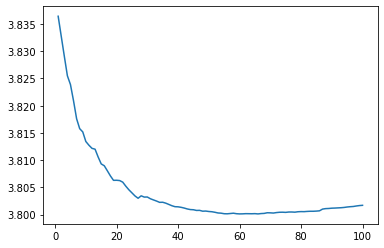

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.plot(x_coords, y_coords)

In [ ]:
rmseArray.index(min(y_coords))

66

In [ ]:
# training set Cross Validation RMSE (WITH MODEL OF 66 MOST IMPORTANT FEATURES):
print(min(y_coords))

3.800121909521974


In [ ]:
X_to_fit = SelectKBest(f_regression, k=66).fit_transform(x_train,y_train)

In [ ]:
clf = LinearRegression()
clf.fit(X_to_fit, y_train)

LinearRegression()

In [ ]:
X_to_fit2 = SelectKBest(f_regression, k=66)
X_to_fit2.fit(x_train,y_train)
list_of_key_features = list()
list_of_key_features = X_to_fit2.get_support(indices = True)

In [ ]:
# roundabout way to make a new df with 67 most important features, but it does the job
inverse_list_of_key_features = []
for i, v in enumerate(range(X.shape[1])):
    inverse_list_of_key_features.append(i)

for i in list_of_key_features:
    inverse_list_of_key_features.remove(i)

x_holdout_truncated = x_holdout.drop(x_holdout.columns[inverse_list_of_key_features], axis=1)

In [ ]:
y_holdout_preds = clf.predict(x_holdout_truncated)

In [ ]:
RMSE = metrics.mean_squared_error(y_holdout, y_holdout_preds)
print(RMSE)

14.309159417222773


The RMSE of our Linear Regression Model is 14.309.

## Predicting With Multinomial Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

def logisticRegressionCrossValidation(X, y):
    LogRegM = LogisticRegression(multi_class = 'multinomial')
    scores = cross_val_score(LogRegM, X, y, cv=10, scoring = 'accuracy')
    average = scores.mean()
    return average

In [ ]:
# accuracy score when classifying with all features
logisticRegressionCrossValidation(x_train_classify, y_train_classify)

0.9018091194388038

In [ ]:
# loop through all the features to see the change in RMSE
featureCount2 = x_train.shape[1]
accuracyArray = []
for i in range(featureCount2):
    X_new = SelectKBest(chi2, k=i).fit_transform(x_train_classify,y_train_classify)
    accuracyArray.append(logisticRegressionCrossValidation(X_new, y_train_classify))

x_coords2 = []
y_coords2 = []
for i, v in enumerate(accuracyArray):
    x_coords2.append(i)
    y_coords2.append(v)
x_coords2 = x_coords2[1:]
y_coords2 = y_coords2[1:]

69


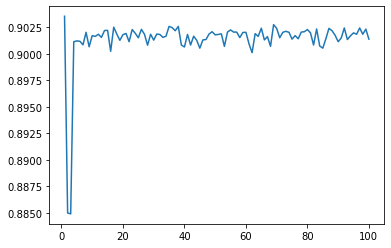

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.plot(x_coords2, y_coords2)

print(accuracyArray.index(max(y_coords2[1:])))

Graph shows that the model is not really overfitting, regardless of how many features is being used. This is likely due to the low weights given to a majority of the feautres. Therefore, we will keep all the features

In [ ]:
LogRegclf = LogisticRegression()
LogRegclf.fit(x_train_classify, y_train_classify)

LogisticRegression()

In [ ]:
y_holdout_2_preds = LogRegclf.predict(x_holdout_classify)
Accuracy = metrics.accuracy_score(y_holdout_classify, y_holdout_2_preds)
print(Accuracy)

0.8967732407885993


Accuracy score from Multinomial Logistic Regression with is 89.67% (tested on holdout set).

## Predicting With Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(x_train_classify, y_train_classify)

RandomForestClassifier()

In [ ]:
# Cross Validation accuracy of Random Forest Classifier 
rfc_cv_score = cross_val_score(rfc, x_train_classify, y_train_classify, cv=10, scoring='accuracy')
print("=== Mean Accuracy Score ===")
print("Mean Accuracy Score - Random Forest: ", rfc_cv_score.mean())

=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9579841240539043


In [ ]:
# Test accuracy of Random Forest Classifier
rfc_preds = rfc.predict(x_holdout_classify)
Accuracy2 = metrics.accuracy_score(y_holdout_classify, rfc_preds)
print(Accuracy2)

0.960570036181053


In [ ]:
# n_estimators = [1,2,3,4,5,10,25,50,100]

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# # number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # number of features at every split
# max_features = ["auto", "sqrt"]
# # max depth
# max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
# max_depth.append(None)
# # create random grid
# random_grid = {
#  "n_estimators": n_estimators,
#  "max_features": max_features,
#  "max_depth": max_depth
#  }

In [ ]:
# # Random search of parameters
# rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
# # Fit the model
# rfc_random.fit(x_train_classify, y_train_classify)

In [ ]:
# # print results
# print(rfc_random.best_params_)

In [ ]:
# # new random forest classifier tuned with the hyperparameters using the cross validation above
# rfc_tuned = RandomForestClassifier(n_estimators=600, max_depth=300, max_features='sqrt')
# rfc_tuned.fit(x_train_classify,y_train)
# rfc_tuned_predict = rfc_tuned.predict(X_test)
# rfc_tuned_cv_score = cross_val_score(rfc_tuned, x_train_classify, y_train_classify, cv=10, scoring='roc_auc')

KeyboardInterrupt: 